In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
card_values = {
    'yes': 1,
    'no': 0
}
df['card'] = df.card.map(card_values)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

#1. 
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- reports
- dependents
- active
- share

In [6]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [7]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(c, auc.round(3))

reports 0.712
age 0.514
income 0.59
share 0.99
expenditure 0.992
dependents 0.529
months 0.523
majorcards 0.536
active 0.61


- Answer for Q1 is **share**.

#Training the model

- From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

- Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [8]:
columns = numerical + categorical

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

#2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [9]:
auc = roc_auc_score(y_val, y_pred)
auc.round(3)

0.994

#3
Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
- At which threshold precision and recall curves intersect?
 - 0.1
 - 0.3
 - 0.6
 - 0.8

In [18]:
def confusion_matrix(y_val, y_pred):
    
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()

        scores.append((t, tp, fp, tn, fn))
    
    columns = ['thresholds', 'tp', 'fp', 'tn', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [19]:
df_scores = confusion_matrix(y_val, y_pred)
df_scores[::10]

,thresholds,tp,fp,tn,fn
0,0.0,168,43,0,0
10,0.1,167,13,30,1
20,0.2,164,4,39,4
30,0.3,162,4,39,6
40,0.4,161,1,42,7
50,0.5,161,1,42,7
60,0.6,161,1,42,7
70,0.7,161,1,42,7
80,0.8,161,1,42,7
90,0.9,161,0,43,7


In [20]:
df_scores['p'] = (df_scores.tp / (df_scores.tp + df_scores.fp))
df_scores['r'] = (df_scores.tp / (df_scores.tp + df_scores.fn))

In [33]:
df_scores.thresholds[df_scores.p == df_scores.r]

18    0.18
19    0.19
20    0.20
21    0.21
22    0.22
23    0.23
Name: thresholds, dtype: float64

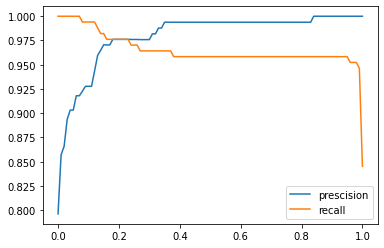

In [22]:
plt.plot(df_scores.thresholds, df_scores['p'], label= 'prescision')
plt.plot(df_scores.thresholds, df_scores['r'], label= 'recall')
plt.legend()

- Answer for Q3 is ~0.3

#4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing 
F1:

F1 = 2PR / (P + R)

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?
 - 0.1
 - 0.4
 - 0.6
 - 0.7

In [24]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [30]:
df_scores['f1'].max()

0.9788519637462235

In [32]:
df_scores.thresholds[df_scores['f1'] == df_scores['f1'].max()]

35    0.35
36    0.36
37    0.37
Name: thresholds, dtype: float64

- Answer for Q4 is ~0.4

#5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation
- How large is standard devidation of the AUC scores across different folds?

 - 0.003
 - 0.014
 - 0.09
 - 0.24


In [35]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card
    y_val = df_val.card

    columns = numerical + categorical

    train_dicts = df_train[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dicts = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(np.std(scores).round(3))

0.003


#6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
- Which C leads to the best mean score?

 - 0.01
 - 0.1
 - 1
 - 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card
        y_val = df_val.card

        columns = numerical + categorical

        train_dicts = df_train[columns].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dicts = df_val[columns].to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(C, np.mean(scores).round(3), np.std(scores).round(3))

0.01 0.992 0.006
0.1 0.995 0.004
1 0.996 0.003
10 0.996 0.003


- Answer for Q6 is C=1